In [1]:
import gradio as gr
from utils.pipeline import DiffUTEPipeline
from Onomatopoeia.Onomato_translation import find_similar_korean_onomatopoeia
from Onomatopoeia.input_similar import find_most_similar_word_from_OCR
import torch

from torchvision import transforms as tf
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import glob, os
import easyocr

def resize_cv2(input_image, w, h):
    output = input_image.resize((w, h))
    # output = np.array(output)
    # return output[:, :, ::-1]
    return output

def load_model():
    pipe = DiffUTEPipeline('cuda:0')
    ckpt = torch.load('./pytorch_model.bin', map_location='cpu')
    pipe.unet.load_state_dict(ckpt)
    return pipe

def get_OCR_result(init_img):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,'
    reader = easyocr.Reader(['ko', 'en'])
    result = reader.readtext(np.array(init_img)) # PIL to cv2 (but RGB is not changed)
    
    return result

def make_mask_image(init_img, mask_text):
    result = get_OCR_result(init_img)
    
    for pts, text, p in result :
        if text == mask_text :
            mask_img = np.zeros_like(init_img)
            cv2.fillConvexPoly(mask_img, np.array(pts, dtype=np.int32), (255, 255, 255))
            break

    return Image.fromarray(mask_img), np.array(pts)

def crop_center(image, pts) :
    pts = np.array(pts) # (4, 2)
    
    cp = np.mean(pts, axis=0)
    w, h = image.size
    d = min(w, h)
    if w < h : 
        ltx, rtx = 0, d
        lty = min(max(0, cp[1]- d//2), max(0, min(cp[1] + d//2, h) - d))
        rty = lty + d
    else : 
        lty, rty = 0, d
        ltx = min(max(0, cp[0]- d//2), max(0, min(cp[0] + d//2, w) - d))
        rtx = ltx + d
    
    
    crop_pts = (int(ltx), int(lty), int(rtx), int(rty))
    return image.crop(crop_pts), crop_pts
        
def generate_image(init_img, mask_text, prompt):
    init_img = Image.fromarray(init_img)
    width, height = init_img.size

    mask_img, pts = make_mask_image(init_img, mask_text)
    
    crop_init_img, crop_pts = crop_center(init_img, pts)
    crop_mask_img, crop_pts = crop_center(mask_img, pts)
    
    w, h = crop_init_img.size
    output_image = pipe.sample(crop_init_img.resize((512, 512)), crop_mask_img.resize((512, 512)), prompt)
    output_image = output_image.resize((w, h))
    
    init_img.paste(output_image, (crop_pts[0], crop_pts[1]))
    return init_img
    # return init_img

def onomato_trans(input_text):
    return find_similar_korean_onomatopoeia(input_text)
    
def auto_onomato_generation(init_img, input_text):
    init_img = Image.fromarray(init_img)
    width, height = init_img.size

    mask_text = auto_Onomato_detection(init_img, input_text) # 끼기긱 -> 끼개각
    mask_img, pts = make_mask_image(init_img, mask_text) # make mask
    # prompt = find_similar_korean_onomatopoeia(mask_text)
    prompt = find_similar_korean_onomatopoeia(input_text) # Onomato 번역은 원본 텍스트로 (not 끼개각, 끼기긱)
    
    
    crop_init_img, crop_pts = crop_center(init_img, pts)
    crop_mask_img, crop_pts = crop_center(mask_img, pts)
    
    w, h = crop_init_img.size
    output_image = pipe.sample(crop_init_img.resize((512, 512)), crop_mask_img.resize((512, 512)), prompt)
    output_image = output_image.resize((w, h))
    
    init_img.paste(output_image, (crop_pts[0], crop_pts[1]))
    return mask_text, init_img

def auto_onomato_generation_test(init_img, input_text):
    init_img = Image.fromarray(init_img)
    width, height = init_img.size

    mask_text = auto_Onomato_detection(init_img, input_text) # 끼기긱 -> 끼개각
    mask_img, pts = make_mask_image(init_img, mask_text) # make mask
    # prompt = find_similar_korean_onomatopoeia(mask_text)
    prompt = find_similar_korean_onomatopoeia(input_text) # Onomato 번역은 원본 텍스트로 (not 끼개각, 끼기긱)
    
    
    crop_init_img, crop_pts = crop_center(init_img, pts)
    crop_mask_img, crop_pts = crop_center(mask_img, pts)
    
    # w, h = crop_init_img.size
    # output_image = pipe.sample(crop_init_img.resize((512, 512)), crop_mask_img.resize((512, 512)), prompt)
    # output_image = output_image.resize((w, h))
    
    # init_img.paste(output_image, (crop_pts[0], crop_pts[1]))
    return crop_init_img

def auto_Onomato_detection(init_img, input_text):
    result = get_OCR_result(init_img)
    
    OCR_list = []
    for pts, text, p in result:
        OCR_list.append(text)
    
    return find_most_similar_word_from_OCR(input_text, OCR_list)

pipe = load_model()
    

/home/taejukwon/anaconda3/envs/textdiffuser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
img_1 = cv2.imread("/mnt/c/Users/USER/LABis/DiffUTE/figure/LIMIT.jpg")

In [13]:
init_img = cv2.imread("/mnt/c/Users/USER/LABis/DiffUTE/sample_output/sweethome1.png")

In [23]:
init_2_img = cv2.imread("/mnt/c/Users/USER/LABis/DiffUTE/figure/webtoon1.jpg")

In [15]:
result = get_OCR_result(init_img)

In [16]:
result

[([[135, 54], [228, 54], [228, 98], [135, 98]], 'Creeak', 0.9274699768914576)]

In [24]:
mask, pts = make_mask_image(init_2_img, "끼개각")

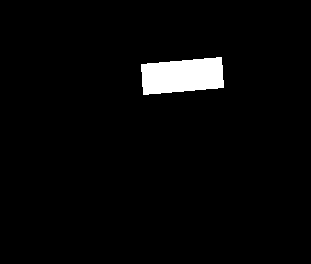

In [25]:
mask

In [26]:
pts

array([[141.54307121,  64.37752817],
       [221.71950038,  57.73338338],
       [223.45692879,  87.62247183],
       [143.28049962,  94.26661662]])

In [8]:
pts[0]

array([327, 238])

In [32]:
cp = np.mean(pts, axis=0)

In [33]:
cp

array([429., 280.])

In [19]:
img_2 = Image.fromarray(init_img)

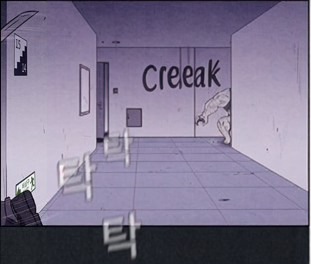

In [27]:
img_2

In [20]:
w, h = img_2.size

In [34]:
img3 = img_2.crop((pts[0][0]*0.95, pts[0][1]*0.95, pts[2][0]*1.05, pts[2][1]*1.05))

In [35]:
img3